In [1]:
%load_ext autoreload
%autoreload 2
import os
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
from SRtools import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
import numpy as np
from SRtools import SR_hetro as srh
from SRtools import presets
import matplotlib.pyplot as plt
from SRtools import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox
from SRtools import utils


In [2]:
save_fig = True
filetype = 'pdf'
path ='results/summery_mode.csv'
lifespan_param = 'best fit no ext hazard_MedianLifetime'

In [3]:
# columns=[
#     'ecoli',
#     'mice_M', 'mice_F', 'yeast', 'celegance', 
#     'cats_BPH', 
#     'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217',
#     'humans_M_combined', 'humans_F_combined', 
#     'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass'
#     ]

columns = ['mice_F','mice_M','yeast','ecoli','cats_vp_M', 'cats_vp_F',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        #'Sweden_M_1910_hetro','Sweden_F_1910_hetro','Denmark_M_1900_hetro','Denmark_M_1890_hetro',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        #'Denmark_F_1890_hetro', 'Denmark_F_1900_hetro'
        'celegans','Guiniea_pig_VC','combined_human_F','combined_human_M']

values_by_param, ci_by_param, selected_value_columns = utils.read_summary_csv(path,columns=columns)
# sil = utils.get_summery_csv_df(columns=columns)

In [4]:
print(values_by_param.keys())


dict_keys(['xc/eta', 'beta/eta', 'xc^2/epsilon', 'xc', 'eta', 'beta', 'epsilon', 'sqrt(xc/eta)', 's= eta^0.5*xc^1.5/epsilon', 'beta*xc/epsilon', 'eta*xc/epsilon', 'Fx=beta^2/eta*xc', 'Dx =beta*epsilon/eta*xc^2', 'Pk=beta*k/epsilon', 'Fk=beta^2/eta*k', 'Dk =beta*epsilon/eta*k^2', 'Fk^2/Dk=beta^3/eta*epsilon', 'epsilon/beta^2', 'k/beta', 'k^2/epsilon', 'best fit no ext hazard_MedianLifetime', 'best fit no ext hazard_MaxLifetime', 'best fit_MedianLifetime', 'best fit_MaxLifetime', 'data_MedianLifetime', 'data_MaxLifetime', 'ML_lnprob', 'ExtH', 'eta/xc', 'beta/xc', 'epsilon/xc^2', 'k/xc'])


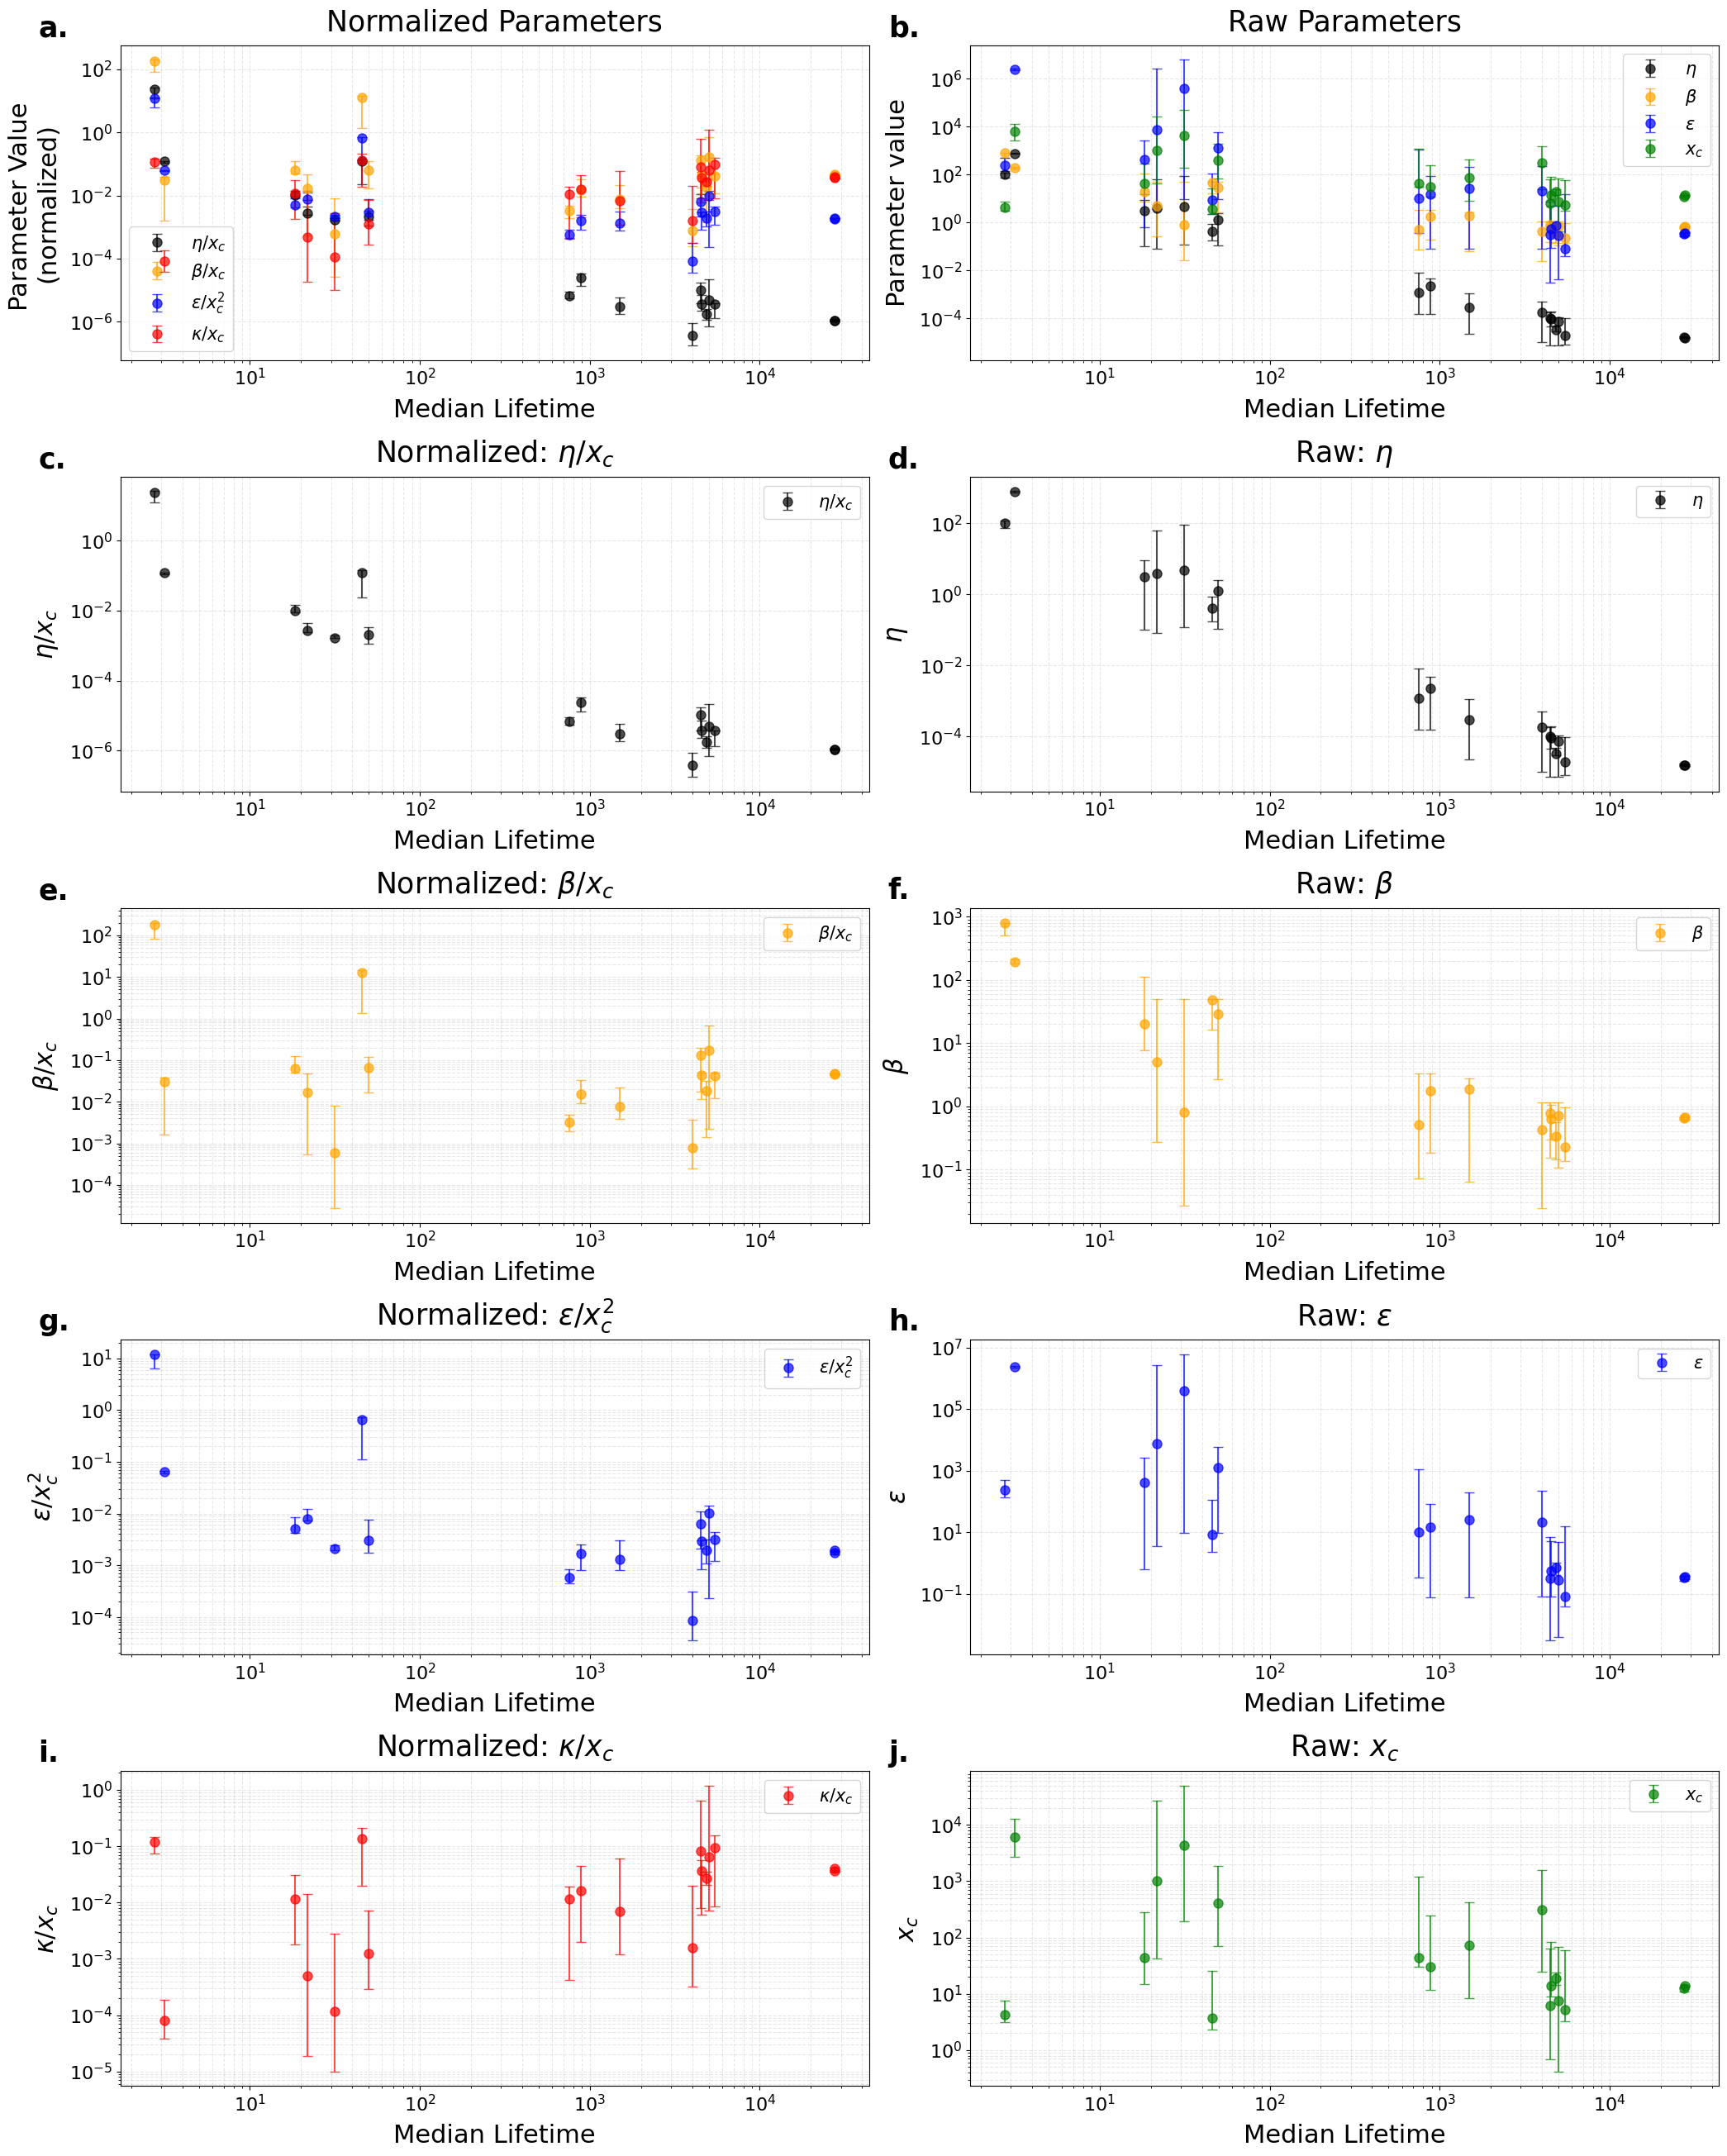

In [15]:
# ---------------- ADJUSTABLE FONT SIZES AND ALPHA VALUES ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Main twin panel (top row) and 8 single-param panels (2 columns x 4 rows)
NROW = 5  # 1 + 4 individual parameters = 5 rows
NCOL = 2
FIGSIZE = (21, 27)
FS_TICK_LABEL = 16
FS_LABEL = 22
FS_LEGEND = 15
FS_TITLE = 25

ALPHA_DATA = 0.7
PANEL_LETTERS = 'abcdefghij'

ML = np.array(values_by_param[lifespan_param])

# --- Normalized parameters: eta/xc, beta/xc, epsilon/xc^2, k/xc
eta_norm = np.array(values_by_param['eta/xc'])
eta_norm_ci = np.array(ci_by_param['eta/xc'])
beta_norm = np.array(values_by_param['beta/xc'])
beta_norm_ci = np.array(ci_by_param['beta/xc'])
epsilon_norm = np.array(values_by_param['epsilon/xc^2'])
epsilon_norm_ci = np.array(ci_by_param['epsilon/xc^2'])
k_norm = np.array(values_by_param['k/xc'])
k_norm_ci = np.array(ci_by_param['k/xc'])

# --- Raw parameters: eta, beta, epsilon, xc (NO k in raw params)
eta = np.array(values_by_param['eta'])
eta_ci = np.array(ci_by_param['eta'])
beta = np.array(values_by_param['beta'])
beta_ci = np.array(ci_by_param['beta'])
epsilon = np.array(values_by_param['epsilon'])
epsilon_ci = np.array(ci_by_param['epsilon'])
xc = np.array(values_by_param['xc'])
xc_ci = np.array(ci_by_param['xc'])
# DO NOT include k in raw params

# Helper for error bars
def extract_asym_errors(y, ci, is_absolute_range=True):
    ci = np.array(ci)
    y = np.array(y)
    if ci.shape == (2, len(y)):
        ci = ci.T
    if ci.shape[1] != 2:
        err_minus = err_plus = np.zeros_like(y)
    else:
        if is_absolute_range:
            err_minus = np.abs(y - ci[:, 0])
            err_plus = np.abs(ci[:, 1] - y)
        else:
            err_minus = np.abs(ci[:, 0])
            err_plus = np.abs(ci[:, 1])
    return err_minus, err_plus

# Color assignments (same for both main and split)
colors_norm = {
    'eta_norm': 'k',
    'beta_norm': 'orange',
    'epsilon_norm': 'b',
    'k_norm': 'r'
}
colors_raw = {
    'eta': 'k',
    'beta': 'orange',
    'epsilon': 'b',
    'xc': 'g'
    # 'k' is intentionally omitted for raw
}
labels_norm = {
    'eta_norm': r'$\eta/x_c$',
    'beta_norm': r'$\beta/x_c$',
    'epsilon_norm': r'$\epsilon/x_c^2$',
    'k_norm': r'$\kappa/x_c$'
}
labels_raw = {
    'eta': r'$\eta$',
    'beta': r'$\beta$',
    'epsilon': r'$\epsilon$',
    'xc': r'$x_c$'
    # 'k' is intentionally omitted for raw
}

params_norm = [
    ("eta_norm", eta_norm, eta_norm_ci),
    ("beta_norm", beta_norm, beta_norm_ci),
    ("epsilon_norm", epsilon_norm, epsilon_norm_ci),
    ("k_norm", k_norm, k_norm_ci),
]
params = [
    ("eta", eta, eta_ci),
    ("beta", beta, beta_ci),
    ("epsilon", epsilon, epsilon_ci),
    ("xc", xc, xc_ci)
    # Do not include k in raw params
]

# For the main panel, use the 4 normalized (as above) and the 4 raw (NO k)
fig, axs = plt.subplots(NROW, NCOL, figsize=FIGSIZE, sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.38, wspace=0.23)

x = ML

# -------------- Top Row: Main "All-In-One" Panels (Normalized and Raw)
# LEFT MAIN: Normalized params
ax = axs[0, 0]

for name, y, yci in params_norm:
    y = np.array(y, dtype=np.float64)
    err_minus, err_plus = extract_asym_errors(y, yci, is_absolute_range=True)
    y = y.flatten()
    err_minus = err_minus.flatten()
    err_plus = err_plus.flatten()
    x_ = x.flatten()
    valid = (~np.isnan(x_)) & (~np.isnan(y)) & np.isfinite(y) & np.isfinite(err_minus) & np.isfinite(err_plus) \
         & (err_minus > 0) & (err_plus > 0)
    x_valid = x_[valid]
    y_valid = y[valid]
    err_minus_valid = err_minus[valid]
    err_plus_valid = err_plus[valid]
    if len(x_valid) < 1:
        continue
    col = colors_norm[name]
    yerr_asym = np.vstack((err_minus_valid, err_plus_valid))
    ax.errorbar(x_valid, y_valid, yerr=yerr_asym, fmt='o', color=col,
                alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10, label=labels_norm[name])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
ax.set_ylabel('Parameter Value \n(normalized)', fontsize=FS_LABEL, labelpad=8)
ax.set_title('Normalized Parameters', fontsize=FS_TITLE, pad=13)
ax.tick_params(axis='both', labelsize=FS_TICK_LABEL)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.legend(fontsize=FS_LEGEND, loc='best', frameon=True, handlelength=2.4)
# Panel label
ax.text(
    -0.11, 1.1, f'{PANEL_LETTERS[0]}.', transform=ax.transAxes, fontsize=FS_TITLE, weight='bold',
    va='top', ha='left'
)

# RIGHT MAIN: Raw params (NO k)
ax = axs[0, 1]
for name, y, yci in zip(['eta', 'beta', 'epsilon', 'xc'],
                        [eta, beta, epsilon, xc],
                        [eta_ci, beta_ci, epsilon_ci, xc_ci]):
    y = np.array(y, dtype=np.float64)
    err_minus, err_plus = extract_asym_errors(y, yci, is_absolute_range=True)
    y = y.flatten()
    err_minus = err_minus.flatten()
    err_plus = err_plus.flatten()
    x_ = x.flatten()
    valid = (~np.isnan(x_)) & (~np.isnan(y)) & np.isfinite(y) & np.isfinite(err_minus) & np.isfinite(err_plus) \
         & (err_minus > 0) & (err_plus > 0)
    x_valid = x_[valid]
    y_valid = y[valid]
    err_minus_valid = err_minus[valid]
    err_plus_valid = err_plus[valid]
    if len(x_valid) < 1:
        continue
    col = colors_raw[name]
    yerr_asym = np.vstack((err_minus_valid, err_plus_valid))
    ax.errorbar(x_valid, y_valid, yerr=yerr_asym, fmt='o', color=col,
                alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10, label=labels_raw[name])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
ax.set_ylabel('Parameter value', fontsize=FS_LABEL, labelpad=8)
ax.set_title('Raw Parameters', fontsize=FS_TITLE, pad=13)
ax.tick_params(axis='both', labelsize=FS_TICK_LABEL)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.legend(fontsize=FS_LEGEND, loc='best', frameon=True, handlelength=2.4)
ax.text(
    -0.11, 1.1, f'{PANEL_LETTERS[1]}.', transform=ax.transAxes, fontsize=FS_TITLE, weight='bold',
    va='top', ha='left'
)

# -------------- Lower Rows: Individual param pairs (normalized left, raw right)
indiv_params_order = [
    ('eta_norm', 'eta'),
    ('beta_norm', 'beta'),
    ('epsilon_norm', 'epsilon'),
    ('k_norm', 'xc')  # Only plot norm for 'k', skip raw 'k'
]
for i, (p_norm_name, p_raw_name) in enumerate(indiv_params_order):
    axl = axs[1+i, 0]
    axr = axs[1+i, 1]
    # --- Normalized (left)
    if p_norm_name == 'eta_norm':
        y_norm = eta_norm
        y_norm_ci = eta_norm_ci
    elif p_norm_name == 'beta_norm':
        y_norm = beta_norm
        y_norm_ci = beta_norm_ci
    elif p_norm_name == 'epsilon_norm':
        y_norm = epsilon_norm
        y_norm_ci = epsilon_norm_ci
    elif p_norm_name == 'k_norm':
        y_norm = k_norm
        y_norm_ci = k_norm_ci
    else:
        y_norm = None
        y_norm_ci = None
    if y_norm is not None:
        err_minus, err_plus = extract_asym_errors(y_norm, y_norm_ci, is_absolute_range=True)
        y = y_norm.flatten()
        err_minus = err_minus.flatten()
        err_plus = err_plus.flatten()
        x_ = x.flatten()
        valid = (~np.isnan(x_)) & (~np.isnan(y)) & np.isfinite(y) & np.isfinite(err_minus) & np.isfinite(err_plus) \
             & (err_minus > 0) & (err_plus > 0)
        x_valid = x_[valid]
        y_valid = y[valid]
        err_minus_valid = err_minus[valid]
        err_plus_valid = err_plus[valid]
        col = colors_norm[p_norm_name]
        yerr_asym = np.vstack((err_minus_valid, err_plus_valid))
        axl.errorbar(x_valid, y_valid, yerr=yerr_asym, fmt='o', color=col,
                    alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10, label=labels_norm[p_norm_name])
        axl.set_xscale('log')
        axl.set_yscale('log')
        axl.set_xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
        axl.set_ylabel(f"{labels_norm[p_norm_name]}", fontsize=FS_LABEL, labelpad=8)
        axl.set_title(f"Normalized: {labels_norm[p_norm_name]}", fontsize=FS_TITLE, pad=13)
        axl.grid(True, which='both', linestyle='--', alpha=0.3)
        axl.tick_params(axis='both', labelsize=FS_TICK_LABEL)
        axl.legend(fontsize=FS_LEGEND, loc='best', frameon=True)
        axl.text(
            -0.11, 1.1, f'{PANEL_LETTERS[2 + 2*i]}.', transform=axl.transAxes, fontsize=FS_TITLE, weight='bold',
            va='top', ha='left'
        )

    # --- Raw (right): ONLY for eta, beta, epsilon, xc; skip for k
    if p_raw_name is None:
        axr.axis('off')
        continue
    if p_raw_name == 'eta':
        y_raw = eta
        y_raw_ci = eta_ci
    elif p_raw_name == 'beta':
        y_raw = beta
        y_raw_ci = beta_ci
    elif p_raw_name == 'epsilon':
        y_raw = epsilon
        y_raw_ci = epsilon_ci
    elif p_raw_name == 'xc':
        y_raw = xc
        y_raw_ci = xc_ci
    else:
        y_raw = None
        y_raw_ci = None
    if y_raw is not None:
        err_minus, err_plus = extract_asym_errors(y_raw, y_raw_ci, is_absolute_range=True)
        y = y_raw.flatten()
        err_minus = err_minus.flatten()
        err_plus = err_plus.flatten()
        x_ = x.flatten()
        valid = (~np.isnan(x_)) & (~np.isnan(y)) & np.isfinite(y) & np.isfinite(err_minus) & np.isfinite(err_plus) \
             & (err_minus > 0) & (err_plus > 0)
        x_valid = x_[valid]
        y_valid = y[valid]
        err_minus_valid = err_minus[valid]
        err_plus_valid = err_plus[valid]
        if p_raw_name in colors_raw:
            col = colors_raw[p_raw_name]
            lab = labels_raw[p_raw_name]
            yerr_asym = np.vstack((err_minus_valid, err_plus_valid))
            axr.errorbar(x_valid, y_valid, yerr=yerr_asym, fmt='o', color=col,
                        alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10, label=lab)
            axr.set_xscale('log')
            axr.set_yscale('log')
            axr.set_xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
            axr.set_ylabel(f"{lab}", fontsize=FS_LABEL, labelpad=8)
            axr.set_title(f"Raw: {lab}", fontsize=FS_TITLE, pad=13)
            axr.grid(True, which='both', linestyle='--', alpha=0.3)
            axr.tick_params(axis='both', labelsize=FS_TICK_LABEL)
            axr.legend(fontsize=FS_LEGEND, loc='best', frameon=True)
            axr.text(
                -0.11, 1.1, f'{PANEL_LETTERS[3 + 2*i]}.', transform=axr.transAxes, fontsize=FS_TITLE, weight='bold',
                va='top', ha='left'
            )

# Squeeze layout and supertitle
# fig.suptitle('Trends: Normalized (left) and Raw (right) SR Model Parameters vs Median Lifetime\nTop: all-params, below: one param at a time',weight='bold', fontsize=FS_TITLE+4, y=0.985)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

if save_fig:
    fig.savefig(f'plots/Suplementary_Fig_2_params_and_trends.{filetype}', dpi=300, bbox_inches='tight')

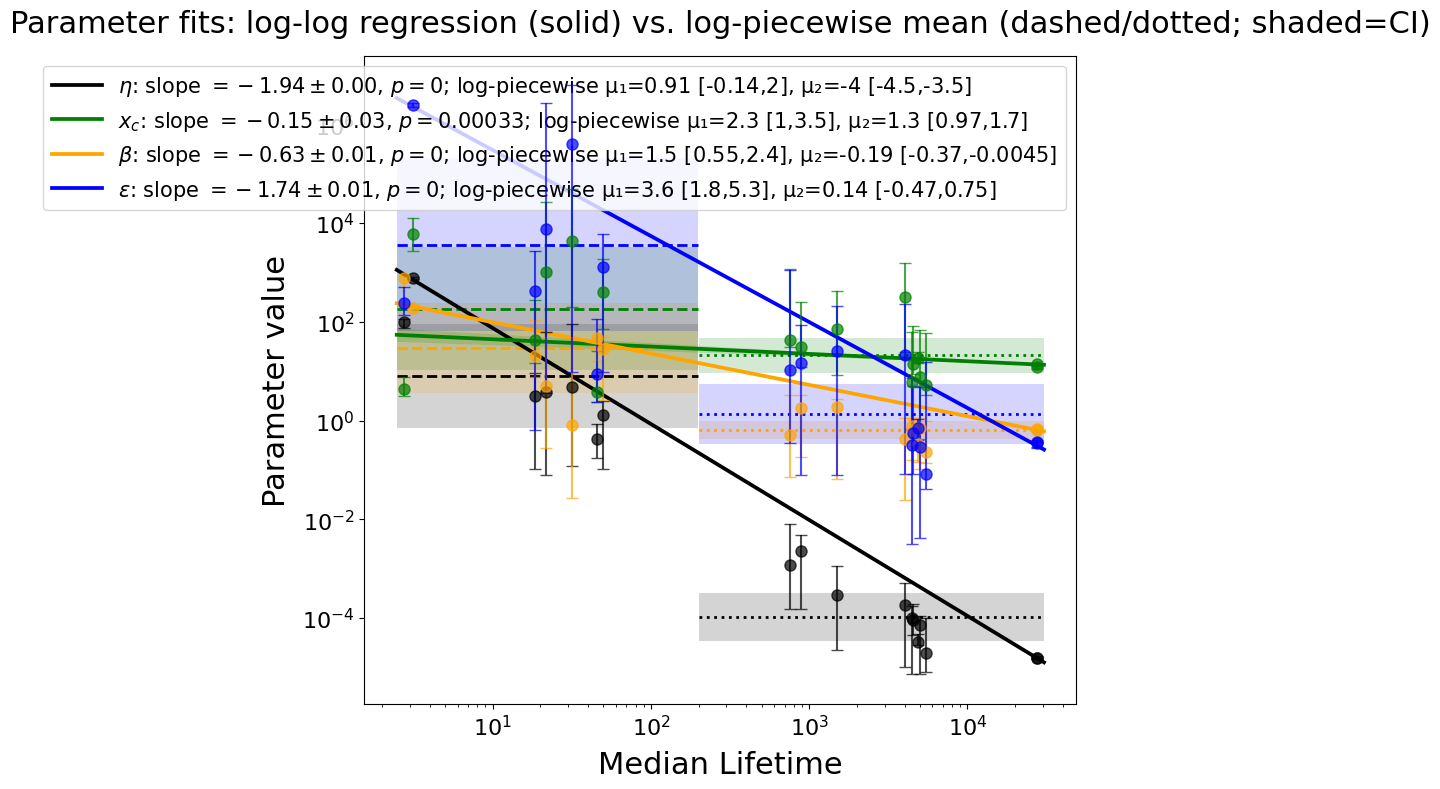


Fit comparison summary (each parameter):
Criteria: AIC (corrected). Model with lower AIC is preferred. (Smaller is better)
eta     : log-log slope = -1.94 ± 0.00304, p=0, AIC=488.27 | log-piecewise means: μ1 (ML<200) = 0.91 [-0.14,2], n=7, μ2 (ML≥200) = -3.98 [-4.5,-3.5], n=11, AIC=-0.94  ==> Two-group (piecewise, log) mean is better (lower AIC)
xc      : log-log slope = -0.148 ± 0.0326, p=0.000328, AIC=123.97 | log-piecewise means: μ1 (ML<200) = 2.27 [1,3.5], n=7, μ2 (ML≥200) = 1.32 [0.97,1.7], n=11, AIC=-0.31  ==> Two-group (piecewise, log) mean is better (lower AIC)
beta    : log-log slope = -0.634 ± 0.00542, p=0, AIC=123.76 | log-piecewise means: μ1 (ML<200) = 1.46 [0.55,2.4], n=7, μ2 (ML≥200) = -0.188 [-0.37,-0.0045], n=11, AIC=-13.44  ==> Two-group (piecewise, log) mean is better (lower AIC)
epsilon : log-log slope = -1.74 ± 0.00941, p=0, AIC=346.76 | log-piecewise means: μ1 (ML<200) = 3.56 [1.8,5.3], n=7, μ2 (ML≥200) = 0.14 [-0.47,0.75], n=11, AIC=13.82  ==> Two-group (piecewis

In [20]:
# ---------------- ADJUSTABLE FONT SIZES AND ALPHA VALUES ----------------
FIGSIZE = (10, 8)
FS_TICK_LABEL = 16
FS_LABEL = 22
FS_LEGEND = 15
FS_TITLE = 22

# --- Adjustable alpha values ---
ALPHA_DATA = 0.7    # alpha for data points
ALPHA_LINE = 1.0    # alpha for fit lines
ALPHA_CONF = 0.17   # alpha for confidence band

ML = values_by_param[lifespan_param]
epsilon = values_by_param['epsilon']
epsilon_ci = ci_by_param['epsilon']
eta = values_by_param['eta']
eta_ci = ci_by_param['eta']
beta = values_by_param['beta']
beta_ci = ci_by_param['beta']
xc = values_by_param['xc']
xc_ci = ci_by_param['xc']

import numpy as np
from scipy.stats import linregress, t

# --- Helper: Convert CI (asym) to lower/upper error per point
def extract_asym_errors(y, ci, is_absolute_range=True):
    ci = np.array(ci)
    y = np.array(y)
    if ci.shape == (2, len(y)):
        ci = ci.T
    if ci.shape[1] != 2:
        err_minus = err_plus = np.zeros_like(y)
    else:
        if is_absolute_range:
            err_minus = np.abs(y - ci[:, 0])
            err_plus = np.abs(ci[:, 1] - y)
        else:
            err_minus = np.abs(ci[:, 0])
            err_plus = np.abs(ci[:, 1])
    return err_minus, err_plus

# --- Helper: Weighted linear regression for asym. errors
def weighted_linear_fit_asym(x, y, err_minus, err_plus):
    logx = np.log10(x)
    logy = np.log10(y)
    logy_err_minus = err_minus / y / np.log(10)
    logy_err_plus = err_plus / y / np.log(10)
    logyerr = np.fmax(logy_err_minus, logy_err_plus)
    weights = 1 / ((logyerr / 1.96) ** 2)
    valid = np.isfinite(logx) & np.isfinite(logy) & np.isfinite(logyerr) & (logyerr > 0)
    logx, logy, logyerr, weights = (logx[valid], logy[valid], logyerr[valid], weights[valid])
    if len(logx) < 2:
        raise ValueError("Not enough points for fit.")
    X = np.vstack([logx, np.ones_like(logx)]).T
    W = np.diag(weights)
    beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ logy)
    b, a = beta_hat[0], beta_hat[1]
    cov = np.linalg.inv(X.T @ W @ X)
    std_slope = np.sqrt(cov[0,0])
    y_fit = b * logx + a
    # after computing logyerr (95% half-width in log space)
    sigma = logyerr / 1.96
    chi2 = np.sum(((logy - y_fit) / sigma)**2)
    # or equivalently: chi2 = (logy - y_fit) @ np.diag(1/sigma**2) @ (logy - y_fit)

    dof = len(logx) - 2
    p_value = 2 * (1 - t.cdf(np.abs(b / std_slope), dof))
    # Compute AIC for model selection
    # n = len(logy), k = 2 (slope and intercept)
    AIC = 2*2 + chi2 + 2*2*(2+1)/(len(logy)-2-1) if len(logy)>3 else np.nan  # Corrected AIC (AICc)
    return a, b, cov, p_value, std_slope, logx, logy, logyerr, valid, chi2, AIC

# --- Helper: Two-parameter piecewise constant fit for log(logy) for ML < 200 and ML >= 200, with CIs
def two_group_piecewise_fit_log_with_cis(x, y, err_minus, err_plus, ml_threshold=200):
    x = np.array(x)
    y = np.array(y)
    logy = np.log10(y)
    logy_err_minus = err_minus / y / np.log(10)
    logy_err_plus = err_plus / y / np.log(10)
    logy_err = np.fmax(logy_err_minus, logy_err_plus)

    group1_mask = x < ml_threshold
    group2_mask = x >= ml_threshold

    def group_stats(logy, logy_err, mask):
        count = np.sum(mask)
        if count == 0:
            return (np.nan, 0, np.nan, (np.nan, np.nan))
        vals = logy[mask]
        errs = logy_err[mask]
        mean = np.mean(vals)
        n = len(vals)
        stderr = np.std(vals, ddof=1) / np.sqrt(n) if n > 1 else (errs[0] if n==1 else np.nan)
        # Compute 95% CI for the mean (t-corrected)
        if n > 1:
            ci_halfwidth = t.ppf(0.975, n-1) * np.std(vals, ddof=1) / np.sqrt(n)
            ci = (mean - ci_halfwidth, mean + ci_halfwidth)
        elif n == 1:
            ci = (mean - errs[0], mean + errs[0])
        else:
            ci = (np.nan, np.nan)
        return (mean, n, stderr, ci)

    mean1_log, n1, stderr1_log, ci1_log = group_stats(logy, logy_err, group1_mask)
    mean2_log, n2, stderr2_log, ci2_log = group_stats(logy, logy_err, group2_mask)

    # Calculate RSS for AIC:  (residual sum of squares, normal errors in log-space)
    rss = 0.0
    for i in range(len(logy)):
        if group1_mask[i]:
            rss += (logy[i] - mean1_log) ** 2
        elif group2_mask[i]:
            rss += (logy[i] - mean2_log) ** 2
    n = n1 + n2
    if n > 2:
        AIC = n * np.log(rss/n) + 2*2 + 2*2*(2+1)/(n-2-1)  # log-likelihood+2k+AICc correction
    else:
        AIC = np.nan

    # Convert log-space CIs to linear space for plotting error bands
    ci1_lin = (10 ** ci1_log[0], 10 ** ci1_log[1])
    ci2_lin = (10 ** ci2_log[0], 10 ** ci2_log[1])

    return (mean1_log, n1, stderr1_log, ci1_log, ci1_lin), (mean2_log, n2, stderr2_log, ci2_log, ci2_lin), \
           group1_mask, group2_mask, rss, AIC

# --- Plotting prep
x = np.array(ML)
colors = {
    'eta': 'k',
    'xc': 'g',
    'beta': 'orange',
    'epsilon': 'b'
}
labels = {
    'eta': r'$\eta$',
    'xc': r'$x_c$',
    'beta': r'$\beta$',
    'epsilon': r'$\epsilon$',
}

params = [
    ("eta", eta, eta_ci), 
    ("xc", xc, xc_ci), 
    ("beta", beta, beta_ci), 
    ("epsilon", epsilon, epsilon_ci)
]

import matplotlib
plt.figure(figsize=FIGSIZE)
x_fit = np.logspace(np.log10(np.nanmin(x)*0.9), np.log10(np.nanmax(x)*1.1), 200)
legend_labels = []   # For fit explanation only
plot_handles = []    # We'll gather handles for legend (one per param, line only)

summary_fits = {}

for name, y, yci in params:
    y = np.array(y, dtype=np.float64)
    is_abs_range = True
    if name not in ['eta', 'xc', 'beta', 'epsilon']:
        is_abs_range = False

    err_minus, err_plus = extract_asym_errors(y, yci, is_absolute_range=True)
    y = y.flatten()
    err_minus = err_minus.flatten()
    err_plus = err_plus.flatten()
    x_ = x.flatten()

    valid = (~np.isnan(x_)) & (~np.isnan(y)) & np.isfinite(y) & np.isfinite(err_minus) & np.isfinite(err_plus) \
         & (err_minus > 0) & (err_plus > 0)
    x_valid = x_[valid]
    y_valid = y[valid]
    err_minus_valid = err_minus[valid]
    err_plus_valid = err_plus[valid]

    if len(x_valid) < 2:
        continue

    # --- Model 1: Linear regression in log-log ---
    try:
        a, b, cov, pval, std_slope, logx_valid, logy_valid, logyerr_fit, _, chi2_lin, AIC_lin = weighted_linear_fit_asym(
            x_valid, y_valid, err_minus_valid, err_plus_valid
        )
    except Exception as e:
        print(f"Skipping {name} fit: {e}")
        continue

    logx_fit = np.log10(x_fit)
    logy_fit = b * logx_fit + a
    y_fit = 10 ** logy_fit

    band_sigma = []
    for lx in logx_fit:
        v = np.array([lx, 1])
        sigma = np.sqrt(np.dot(np.dot(v, cov), v.T))
        band_sigma.append(sigma)
    band_sigma = np.array(band_sigma)
    y_fit_upper = 10 ** (logy_fit + band_sigma)
    y_fit_lower = 10 ** (logy_fit - band_sigma)

    # --- Model 2: Piecewise constant ("two-group") model in log-space with CIs ---
    (mean1_log, n1, stderr1_log, ci1_log, ci1_lin), \
    (mean2_log, n2, stderr2_log, ci2_log, ci2_lin), \
    group1_mask, group2_mask, rss_piecewise, AIC_piecewise = \
        two_group_piecewise_fit_log_with_cis(
            x_valid, y_valid, err_minus_valid, err_plus_valid, ml_threshold=200
        )
    # For plotting: draw horizontal lines and CI bands for each group
    ml_min, ml_max = np.nanmin(x_valid), np.nanmax(x_valid)
    xh = np.logspace(np.log10(ml_min*0.9), np.log10(ml_max*1.1), 500)
    group1_range = (xh < 200)
    group2_range = (xh >= 200)
    yh_piecewise = np.zeros_like(xh)
    yh_piecewise[group1_range] = 10**mean1_log
    yh_piecewise[group2_range] = 10**mean2_log

    # Plot CI band for log-log fit FIRST (for clear zorder)
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=2)

    # Plot linear fit
    (line_handle,) = plt.plot(
        x_fit, y_fit, color=colors[name], linewidth=2.7, label=f"{labels[name]}", zorder=5, alpha=ALPHA_LINE)

    # Piecewise: plot CI bands (in linear space)
    if n1 > 0:
        plt.fill_between(
            xh[group1_range],
            ci1_lin[0], ci1_lin[1],
            color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=3
        )
    if n2 > 0:
        plt.fill_between(
            xh[group2_range],
            ci2_lin[0], ci2_lin[1],
            color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=3
        )
    # Plot piecewise (two-group, on log-scaled y) fit as horizontal dashed lines
    plt.plot(xh[group1_range], yh_piecewise[group1_range], color=colors[name], linestyle='dashed', linewidth=2,
             label=f"{labels[name]} (const. ML<200)", alpha=ALPHA_LINE, zorder=4)
    plt.plot(xh[group2_range], yh_piecewise[group2_range], color=colors[name], linestyle='dotted', linewidth=2,
             label=f"{labels[name]} (const. ML≥200)", alpha=ALPHA_LINE, zorder=4)

    # Plot data (+asym error bars)
    yerr_asym = np.vstack((err_minus_valid, err_plus_valid))
    plt.errorbar(
        x_valid, y_valid, yerr=yerr_asym, fmt='o', color=colors[name], alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10
    )

    legend_labels.append(
        f"{labels[name]}: slope $={b:.2f}\\pm{std_slope:.2f}$, $p={pval:.2g}$; "
        f"log-piecewise μ₁={mean1_log:.2g} [{ci1_log[0]:.2g},{ci1_log[1]:.2g}], "
        f"μ₂={mean2_log:.2g} [{ci2_log[0]:.2g},{ci2_log[1]:.2g}]"
    )
    plot_handles.append(line_handle)

    summary_fits[name] = dict(
        linear=dict(a=a, b=b, slope_std=std_slope, p=pval, chi2=chi2_lin, AIC=AIC_lin),
        piecewise=dict(mean1_log=mean1_log, mean2_log=mean2_log,
                       n1=n1, n2=n2,
                       stderr1_log=stderr1_log, stderr2_log=stderr2_log,
                       ci1_log=ci1_log, ci2_log=ci2_log,
                       ci1_lin=ci1_lin, ci2_lin=ci2_lin,
                       rss=rss_piecewise, AIC=AIC_piecewise)
    )

# --- Axes/label/ticks style
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
plt.ylabel('Parameter value', fontsize=FS_LABEL, labelpad=8)
plt.title('Parameter fits: log-log regression (solid) vs. log-piecewise mean (dashed/dotted; shaded=CI)', 
          fontsize=FS_TITLE, pad=17)

plt.tick_params(axis='both', labelsize=FS_TICK_LABEL)
legend = plt.legend(plot_handles, legend_labels, fontsize=FS_LEGEND, loc='best', frameon=True, handlelength=2.4)
plt.tight_layout()
plt.show()

# --- Print summary and model comparison ---
print('\nFit comparison summary (each parameter):')
print('Criteria: AIC (corrected). Model with lower AIC is preferred. (Smaller is better)')
for name in summary_fits:
    l = summary_fits[name]['linear']
    p = summary_fits[name]['piecewise']

    # Decide which model is better based on AIC (lower is better)
    aic_lin = l['AIC']
    aic_piece = p['AIC']
    if np.isnan(aic_lin) and np.isnan(aic_piece):
        better = "Not enough points for either model"
    elif np.isnan(aic_lin):
        better = "Piecewise constant (AIC only for piecewise available)"
    elif np.isnan(aic_piece):
        better = "Linear log-log (AIC only for linear available)"
    elif aic_lin < aic_piece:
        better = "Linear log-log regression is better (lower AIC)"
    else:
        better = "Two-group (piecewise, log) mean is better (lower AIC)"

    print(
        f"{name:8}: log-log slope = {l['b']:.3g} ± {l['slope_std']:.3g}, p={l['p']:.3g},"
        f" AIC={l['AIC']:.2f} | log-piecewise means: μ1 (ML<200) = {p['mean1_log']:.3g} [{p['ci1_log'][0]:.2g},{p['ci1_log'][1]:.2g}], n={p['n1']},"
        f" μ2 (ML≥200) = {p['mean2_log']:.3g} [{p['ci2_log'][0]:.2g},{p['ci2_log'][1]:.2g}], n={p['n2']},"
        f" AIC={p['AIC']:.2f}  ==> {better}"
    )

# -- Comments explaining the flow:
# (1) For each parameter, extract both directional errors from 95% CI;
# (2) Compare two models: (log-log linear fit with error weighting; and two-group piecewise *in log-space*, with CIs converted to linear for visualization);
# (3) Model comparison by corrected AIC (AICc). Model with lower AIC is preferred. If AIC unavailable, describe reason.
# (4) Plots show both models (solid: linear log-log, dashed/dotted: piecewise log-means and 95%CI error bands in linear space).
# (5) Prints per-parameter fit details and model comparison result (piecewise means and CIs are in log-space/linear-space as noted).
# (6) All font sizes (figure, title, legend, axes) and alpha values are set by variables at top of cell.


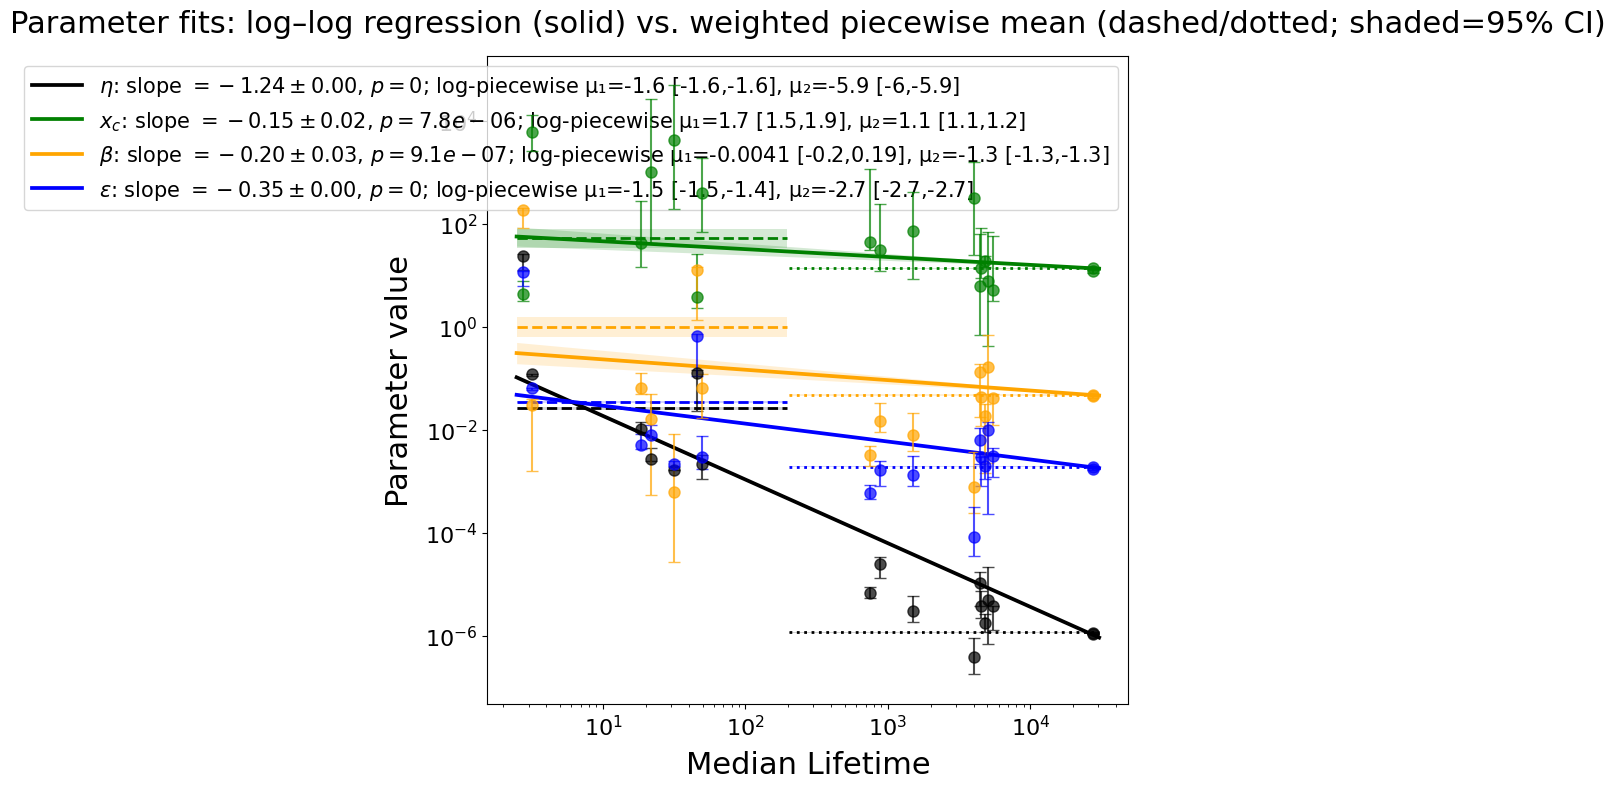


Fit comparison summary (each parameter):
Criteria: AICc with known per-point σ (weighted). Lower is better; comparable across models.
eta     : log–log slope = -1.24 ± 0.00491, p=0, AICc=1236.02 | log-piecewise means: μ1 (ML<200) = -1.58 [-1.6,-1.6], n=7, μ2 (ML≥200) = -5.94 [-6,-5.9], n=11, AICc=3767.22  ==> Linear log–log regression is better (lower AICc)
xc      : log–log slope = -0.153 ± 0.0236, p=7.76e-06, AICc=239.85 | log-piecewise means: μ1 (ML<200) = 1.72 [1.5,1.9], n=7, μ2 (ML≥200) = 1.14 [1.1,1.2], n=11, AICc=243.67  ==> Linear log–log regression is better (lower AICc)
beta    : log–log slope = -0.202 ± 0.0262, p=9.11e-07, AICc=557.02 | log-piecewise means: μ1 (ML<200) = -0.00406 [-0.2,0.19], n=7, μ2 (ML≥200) = -1.33 [-1.3,-1.3], n=11, AICc=446.87  ==> Two-group (piecewise, log) mean is better (lower AICc)
epsilon : log–log slope = -0.348 ± 0.00395, p=0, AICc=1546.54 | log-piecewise means: μ1 (ML<200) = -1.46 [-1.5,-1.4], n=7, μ2 (ML≥200) = -2.72 [-2.7,-2.7], n=11, AICc=211

In [23]:
# ---------------- ADJUSTABLE FONT SIZES AND ALPHA VALUES ----------------
FIGSIZE = (10, 8)
FS_TICK_LABEL = 16
FS_LABEL = 22
FS_LEGEND = 15
FS_TITLE = 22

# --- Adjustable alpha values ---
ALPHA_DATA = 0.7    # alpha for data points
ALPHA_LINE = 1.0    # alpha for fit lines
ALPHA_CONF = 0.17   # alpha for confidence band

# ---- Inputs expected (already defined in your environment) ----
# values_by_param: dict with keys 'data_MedianLifetime','epsilon','eta','beta','xc'
# ci_by_param: dict with keys 'epsilon','eta','beta','xc', each N×2 or 2×N absolute [low, high] 95% CI
ML = values_by_param[lifespan_param]
# epsilon = values_by_param['epsilon'];    epsilon_ci = ci_by_param['epsilon']
# eta     = values_by_param['eta'];        eta_ci     = ci_by_param['eta']
# beta    = values_by_param['beta'];       beta_ci    = ci_by_param['beta']
# xc      = values_by_param['xc'];         xc_ci      = ci_by_param['xc']

epsilon = values_by_param['epsilon/xc^2'];    epsilon_ci = ci_by_param['epsilon/xc^2']
eta     = values_by_param['eta/xc'];        eta_ci     = ci_by_param['eta/xc']
beta    = values_by_param['beta/xc'];       beta_ci    = ci_by_param['beta/xc']
xc      = values_by_param['xc'];         xc_ci      = ci_by_param['xc']


import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

# ------------------------- Helpers -------------------------

def normalize_ci_shape(y, ci):
    """Return ci as N×2 array aligned with y (N,)."""
    y = np.asarray(y).reshape(-1)
    ci = np.asarray(ci)
    if ci.shape == (2, len(y)):
        ci = ci.T
    if ci.shape[0] != len(y) or ci.shape[1] != 2:
        raise ValueError("CI must be shape (N,2) or (2,N) with absolute [low, high] bounds.")
    return y, ci

def log10_with_ci_sigma(y, ci_abs):
    """
    Exact transform to log10-space with 1σ errors derived from given 95% absolute CIs on y.
    Returns:
        logx? (not here), but:
        logy (N,), sigma_logy (N,) where sigma_logy is 1σ in log10-space.
    """
    y, ci = normalize_ci_shape(y, ci_abs)
    # Guard invalid ranges
    low = ci[:, 0].astype(float)
    high = ci[:, 1].astype(float)
    y = y.astype(float)

    # Invalid if <= 0 or reversed CI
    invalid = (y <= 0) | (low <= 0) | (high <= 0) | (high < low)
    logy = np.full_like(y, np.nan, dtype=float)
    sigma_logy = np.full_like(y, np.nan, dtype=float)
    if np.all(invalid):
        return logy, sigma_logy

    # exact half-widths in log10 units from absolute bounds
    _logy = np.log10(y[~invalid])
    loglow = np.log10(low[~invalid])
    loghigh = np.log10(high[~invalid])

    err_minus95 = _logy - loglow
    err_plus95  = loghigh - _logy
    hw95 = np.fmax(err_minus95, err_plus95)  # conservative asymmetric → symmetric

    logy[~invalid] = _logy
    sigma_logy[~invalid] = hw95 / 1.96   # convert 95% half-width → 1σ

    return logy, sigma_logy

def weighted_linear_fit_loglog(x, y, ci_abs):
    """
    Weighted least squares for log10(y) ~ a + b*log10(x), using per-point 1σ from CI.
    Returns:
        a, b, cov(2x2), p_value (slope), std_slope, logx, logy, sigma_logy, valid_mask, chi2, AICc
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    logy, sigma_logy = log10_with_ci_sigma(y, ci_abs)
    logx = np.log10(x)

    valid = np.isfinite(logx) & np.isfinite(logy) & np.isfinite(sigma_logy) & (sigma_logy > 0)
    logx = logx[valid]; logy = logy[valid]; sigma_logy = sigma_logy[valid]
    if len(logx) < 2:
        raise ValueError("Not enough valid points for linear fit.")

    w = 1.0 / (sigma_logy**2)
    X = np.vstack([logx, np.ones_like(logx)]).T
    W = np.diag(w)
    XtWX = X.T @ W @ X
    XtWy = X.T @ W @ logy
    beta_hat = np.linalg.solve(XtWX, XtWy)
    b, a = beta_hat[0], beta_hat[1]  # slope, intercept (remember: y = a + b x)

    cov = np.linalg.inv(XtWX)  # with known σᵢ, this is the parameter covariance
    std_slope = np.sqrt(cov[0, 0])

    y_fit = b * logx + a
    # χ² **with 1σ**:
    chi2 = np.sum(((logy - y_fit) / sigma_logy)**2)
    dof = len(logx) - 2
    # p-value for slope ≠ 0 using t with dof
    p_value = 2 * (1 - t.cdf(np.abs(b / std_slope), dof)) if dof > 0 else np.nan

    # AICc for known-variance Gaussian (drop constants common to both models)
    n = len(logx); k = 2
    if n > (k + 1):
        AICc = chi2 + 2*k + (2*k*(k+1)) / (n - k - 1)
    else:
        AICc = np.nan

    return a, b, cov, p_value, std_slope, logx, logy, sigma_logy, valid, chi2, AICc

def weighted_two_group_piecewise_log(x, y, ci_abs, ml_threshold=200.0):
    """
    Two-parameter model in log10-space: mean1 for x<thr, mean2 for x>=thr.
    Uses weighted means with weights = 1/sigma_logy^2 (1σ from CI).
    Returns:
        group1: (mean_log, n, se_mean_log, (ci_low_log, ci_high_log), (ci_low_lin, ci_high_lin))
        group2: same
        masks, chi2, AICc
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    logy, sigma_logy = log10_with_ci_sigma(y, ci_abs)
    w = 1.0 / (sigma_logy**2)

    valid = np.isfinite(x) & np.isfinite(logy) & np.isfinite(sigma_logy) & (sigma_logy > 0)
    x = x[valid]; logy = logy[valid]; sigma_logy = sigma_logy[valid]; w = w[valid]

    g1 = x < ml_threshold
    g2 = ~g1

    def wstats(vals, wts):
        if vals.size == 0:
            return (np.nan, 0, np.nan, (np.nan, np.nan), (np.nan, np.nan))
        wsum = np.sum(wts)
        mu = np.sum(wts * vals) / wsum
        # SE of weighted mean (known-variance normal): sqrt(1 / Σw)
        se_mu = np.sqrt(1.0 / wsum)
        # 95% CI using normal approx (weights break simple t usage)
        ci = (mu - 1.96*se_mu, mu + 1.96*se_mu)
        ci_lin = (10**ci[0], 10**ci[1])
        return (mu, vals.size, se_mu, ci, ci_lin)

    mean1_log, n1, se1, ci1_log, ci1_lin = wstats(logy[g1], w[g1])
    mean2_log, n2, se2, ci2_log, ci2_lin = wstats(logy[g2], w[g2])

    # Weighted χ² for the piecewise model
    chi2 = 0.0
    if n1 > 0:
        chi2 += np.sum(((logy[g1] - mean1_log) / sigma_logy[valid][g1])**2)
    if n2 > 0:
        chi2 += np.sum(((logy[g2] - mean2_log) / sigma_logy[valid][g2])**2)

    n = n1 + n2; k = 2
    if n > (k + 1):
        AICc = chi2 + 2*k + (2*k*(k+1)) / (n - k - 1)
    else:
        AICc = np.nan

    return (mean1_log, n1, se1, ci1_log, ci1_lin), (mean2_log, n2, se2, ci2_log, ci2_lin), g1, g2, chi2, AICc, valid, logy, sigma_logy

# ------------------------- Plotting prep -------------------------

x = np.asarray(ML, dtype=float).reshape(-1)
colors = {'eta': 'k', 'xc': 'g', 'beta': 'orange', 'epsilon': 'b'}
labels = {'eta': r'$\eta$', 'xc': r'$x_c$', 'beta': r'$\beta$', 'epsilon': r'$\epsilon$'}
params = [("eta", eta, eta_ci), ("xc", xc, xc_ci), ("beta", beta, beta_ci), ("epsilon", epsilon, epsilon_ci)]

plt.figure(figsize=FIGSIZE)
x_fit = np.logspace(np.log10(np.nanmin(x)*0.9), np.log10(np.nanmax(x)*1.1), 200)
legend_labels = []   # for descriptive legend text
plot_handles = []    # line handles only (one per parameter)
summary_fits = {}

for name, y, yci in params:
    y = np.asarray(y, dtype=float).reshape(-1)
    try:
        # --- Model 1: Weighted linear log-log
        a, b, cov, pval, std_slope, logx_v, logy_v, sigma_logy_v, valid_mask_lin, chi2_lin, AICc_lin = \
            weighted_linear_fit_loglog(x, y, yci)
    except Exception as e:
        print(f"Skipping {name} fit: {e}")
        continue

    # Predict & 95% band in log-space, then back-transform
    logx_fit = np.log10(x_fit)
    logy_fit = b * logx_fit + a
    # SE of mean prediction: sqrt(v^T cov v)
    band_se = np.sqrt(np.einsum('ij,ji->i', np.vstack([logx_fit, np.ones_like(logx_fit)]).T @ cov,
                                   np.vstack([logx_fit, np.ones_like(logx_fit)])))
    logy_fit_lo = logy_fit - 1.96 * band_se
    logy_fit_hi = logy_fit + 1.96 * band_se
    y_fit        = 10**logy_fit
    y_fit_lower  = 10**logy_fit_lo
    y_fit_upper  = 10**logy_fit_hi

    # --- Model 2: Weighted two-group piecewise (in log-space)
    (mean1_log, n1, se1, ci1_log, ci1_lin), \
    (mean2_log, n2, se2, ci2_log, ci2_lin), \
    g1, g2, chi2_piece, AICc_piece, valid_mask_piece, logy_piece, sigma_piece = \
        weighted_two_group_piecewise_log(x, y, yci, ml_threshold=200.0)

    # For plotting: draw piecewise horizontal means over x-range
    ml_min, ml_max = np.nanmin(x), np.nanmax(x)
    xh = np.logspace(np.log10(ml_min*0.9), np.log10(ml_max*1.1), 500)
    group1_range = xh < 200.0
    group2_range = ~group1_range
    yh_piecewise = np.where(group1_range, 10**mean1_log, 10**mean2_log)

    # --- Plot layers
    # 1) 95% confidence band for linear fit (draw first)
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=2)
    # 2) Linear fit line
    (line_handle,) = plt.plot(x_fit, y_fit, color=colors[name], linewidth=2.7, label=f"{labels[name]}",
                              zorder=5, alpha=ALPHA_LINE)
    # 3) Piecewise CI bands (in linear space)
    if n1 > 0:
        plt.fill_between(xh[group1_range], ci1_lin[0], ci1_lin[1],
                         color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=3)
    if n2 > 0:
        plt.fill_between(xh[group2_range], ci2_lin[0], ci2_lin[1],
                         color=colors[name], alpha=ALPHA_CONF, linewidth=0, zorder=3)
    # 4) Piecewise mean lines
    if np.any(group1_range):
        plt.plot(xh[group1_range], yh_piecewise[group1_range], color=colors[name],
                 linestyle='dashed', linewidth=2, label=f"{labels[name]} (const. ML<200)",
                 alpha=ALPHA_LINE, zorder=4)
    if np.any(group2_range):
        plt.plot(xh[group2_range], yh_piecewise[group2_range], color=colors[name],
                 linestyle='dotted', linewidth=2, label=f"{labels[name]} (const. ML≥200)",
                 alpha=ALPHA_LINE, zorder=4)

    # 5) Data with asymmetric vertical error bars (from absolute CI)
    #    We'll derive linear-space err_minus/plus just for plotting
    y_, ci_plot = normalize_ci_shape(y, yci)
    err_minus_lin = np.abs(y_ - ci_plot[:, 0])
    err_plus_lin  = np.abs(ci_plot[:, 1] - y_)
    valid_points = np.isfinite(x) & np.isfinite(y_) & (err_minus_lin > 0) & (err_plus_lin > 0)
    yerr_asym = np.vstack((err_minus_lin[valid_points], err_plus_lin[valid_points]))
    plt.errorbar(x[valid_points], y_[valid_points], yerr=yerr_asym, fmt='o',
                 color=colors[name], alpha=ALPHA_DATA, capsize=4, markersize=8, zorder=10)

    legend_labels.append(
        f"{labels[name]}: slope $={b:.2f}\\pm{std_slope:.2f}$, $p={pval:.2g}$; "
        f"log-piecewise μ₁={mean1_log:.2g} [{ci1_log[0]:.2g},{ci1_log[1]:.2g}], "
        f"μ₂={mean2_log:.2g} [{ci2_log[0]:.2g},{ci2_log[1]:.2g}]"
    )
    plot_handles.append(line_handle)

    summary_fits[name] = dict(
        linear=dict(a=a, b=b, slope_std=std_slope, p=pval, chi2=chi2_lin, AIC=AICc_lin),
        piecewise=dict(mean1_log=mean1_log, mean2_log=mean2_log,
                       n1=n1, n2=n2,
                       se1_log=se1, se2_log=se2,
                       ci1_log=ci1_log, ci2_log=ci2_log,
                       ci1_lin=ci1_lin, ci2_lin=ci2_lin,
                       chi2=chi2_piece, AIC=AICc_piece)
    )

# ------------------------- Axes/labels/style -------------------------
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Median Lifetime', fontsize=FS_LABEL, labelpad=8)
plt.ylabel('Parameter value', fontsize=FS_LABEL, labelpad=8)
plt.title('Parameter fits: log–log regression (solid) vs. weighted piecewise mean (dashed/dotted; shaded=95% CI)',
          fontsize=FS_TITLE, pad=17)
plt.tick_params(axis='both', labelsize=FS_TICK_LABEL)
legend = plt.legend(plot_handles, legend_labels, fontsize=FS_LEGEND, loc='best', frameon=True, handlelength=2.4)
plt.tight_layout()
plt.show()

# ------------------------- Summary & model comparison -------------------------
print('\nFit comparison summary (each parameter):')
print('Criteria: AICc with known per-point σ (weighted). Lower is better; comparable across models.')

for name in summary_fits:
    l = summary_fits[name]['linear']
    p = summary_fits[name]['piecewise']

    aic_lin = l['AIC']; aic_piece = p['AIC']
    if np.isnan(aic_lin) and np.isnan(aic_piece):
        better = "Not enough points for either model"
    elif np.isnan(aic_lin):
        better = "Piecewise (only piecewise AICc available)"
    elif np.isnan(aic_piece):
        better = "Linear log–log (only linear AICc available)"
    elif aic_lin < aic_piece:
        better = "Linear log–log regression is better (lower AICc)"
    else:
        better = "Two-group (piecewise, log) mean is better (lower AICc)"

    print(
        f"{name:8}: log–log slope = {l['b']:.3g} ± {l['slope_std']:.3g}, p={l['p']:.3g},"
        f" AICc={l['AIC']:.2f} | log-piecewise means: μ1 (ML<200) = {p['mean1_log']:.3g} "
        f"[{p['ci1_log'][0]:.2g},{p['ci1_log'][1]:.2g}], n={p['n1']},"
        f" μ2 (ML≥200) = {p['mean2_log']:.3g} "
        f"[{p['ci2_log'][0]:.2g},{p['ci2_log'][1]:.2g}], n={p['n2']},"
        f" AICc={p['AIC']:.2f}  ==> {better}"
    )
